In [12]:
import pandas as pd
test_file_path='~/Downloads/test 2.csv'
test_dataset=pd.read_csv(test_file_path)
# use first 50 rows for dataset
test_dataset = test_dataset.head(50)

In [13]:
from dspy_utils import PersonalizedSummary, Assess
import dspy
summarize = dspy.ChainOfThought(PersonalizedSummary)
summarize.load('./optimized_summarizer_miprov2')
assess = dspy.ChainOfThought(Assess)

def test_personalized_summary(df,length=50,style="formal"):
    # empty dictionary to store the results
    results = {}
    documents = []
    summaries = []
    summary_scores = []

    # for each row, get the document and the summary
    for i in range(len(df)):
        document = df.iloc[i]['article']
        summary = summarize(document=document,length=length,style=style,context="").summary

        gt_summary = df.iloc[i]['highlights']
        summary_score = assess(original_document=document,summary=summary, length=length, style=style, context="").score

        documents.append(document)
        summaries.append(summary)
        summary_scores.append(summary_score)
    
    results['documents'] = documents
    results['summaries'] = summaries
    results['summary_scores'] = summary_scores
    return results


# run 3 experiments and get the average score
results = []
for i in range(3):
    results.append(test_personalized_summary(test_dataset))
import numpy as np

def analyze_experiments(results):
    n_experiments = len(results)
    all_summary_scores = [r['summary_scores'] for r in results]
    
    # Calculate average scores across experiments
    avg_summary_scores = np.mean(all_summary_scores, axis=0)
    
    # Calculate standard deviation
    std_summary_scores = np.std(all_summary_scores, axis=0)
    
    # Create summary statistics
    summary_stats = {
        'mean_model_score': np.mean(avg_summary_scores),
        'std_model_score': np.mean(std_summary_scores),
    }
    
    # Create detailed results DataFrame
    detailed_results = pd.DataFrame({
        'documents': results[0]['documents'],  # Use first experiment's documents
        'summaries': results[0]['summaries'],  # Use first experiment's summaries
        'summary_scores': avg_summary_scores,
    })
    
    return summary_stats, detailed_results
summary_stats, detailed_results = analyze_experiments(results)


# result=test_personalized_summary(test_dataset)
result_df=pd.DataFrame(detailed_results)
# save the results to a csv file
result_df.to_csv('~/Downloads/personalized_summary_results_miprov_exp3.csv',index=False)

In [14]:
print(summary_stats)

{'mean_model_score': np.float64(8.246666666666666), 'std_model_score': np.float64(0.3557411865880974)}


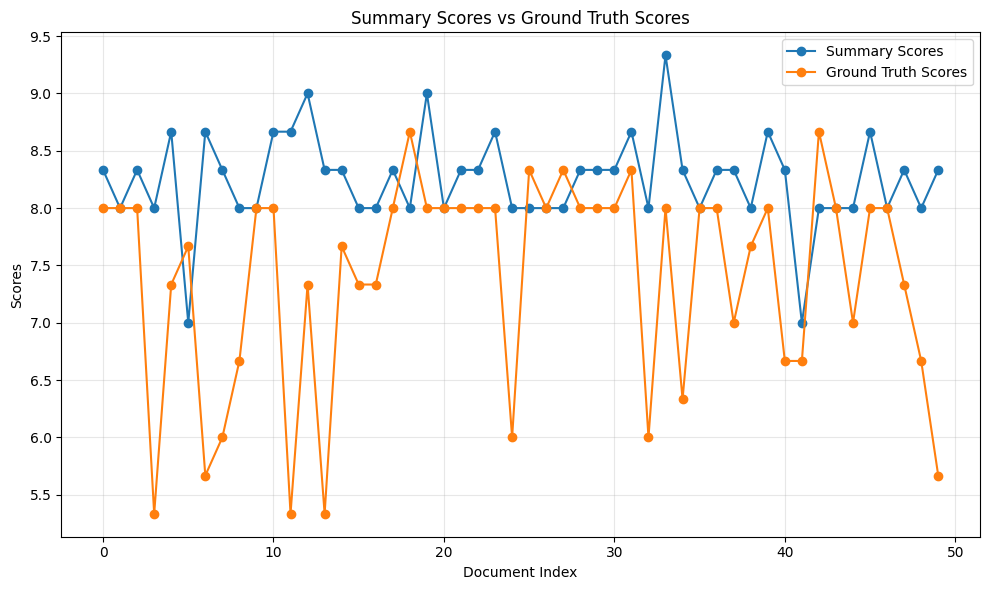

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
res1path='~/Downloads/personalized_summary_results_exp1.csv'
res1=pd.read_csv(res1path)

def plot_score_comparison(df):
    """
    Create a simple line plot comparing summary_scores and gt_scores.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'summary_scores' and 'gt_scores' columns
    """
    # Create figure and axis
    plt.figure(figsize=(10, 6))
    
    # Create line plots for both scores
    plt.plot(df['summary_scores'], marker='o', label='Summary Scores')
    plt.plot(res1['gt_scores'], marker='o', label='Ground Truth Scores')
    
    # Add labels and title
    plt.xlabel('Document Index')
    plt.ylabel('Scores')
    plt.title('Summary Scores vs Ground Truth Scores')
    
    # Add legend
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()

plot_score_comparison(result_df)

In [7]:
dspy.inspect_history(n=2)





[2024-12-07T16:54:03.415384]

System message:

Your input fields are:
1. `original_document` (str): The original document to summarize
2. `length` (int): The maximum length of the summary
3. `style` (str): The style of the summary, either 'formal' or 'casual'
4. `summary` (str): The summary text, evaluated based on whether the length, and style personalization preferences are met

Your output fields are:
1. `reasoning` (str)
2. `score` (int): The score of the summary, between 0 and 10

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## original_document ## ]]
{original_document}

[[ ## length ## ]]
{length}

[[ ## style ## ]]
{style}

[[ ## summary ## ]]
{summary}

[[ ## reasoning ## ]]
{reasoning}

[[ ## score ## ]]
{score}        # note: the value you produce must be a single int value

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `original_document`, `length`, `style`, `sum